In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_inter = pd.read_csv('./data/interactions.csv')
df_items = pd.read_csv('./data/items.csv')
df_users = pd.read_csv('./data/users.csv')

In [3]:
users_in_df_users = set(df_users['user_id'].values)
users_in_df_inter = set(df_inter['user_id'].values)
users_to_stay = users_in_df_users.intersection(users_in_df_inter)

df_users_mask = df_users['user_id'].apply(lambda user: user in users_to_stay)
df_inter_mask = df_inter['user_id'].apply(lambda user: user in users_to_stay)

df_users = df_users[df_users_mask].reset_index(drop=True)
df_inter = df_inter[df_inter_mask].reset_index(drop=True)


items_in_df_items = set(df_items['item_id'].values)
items_in_df_inter = set(df_inter['item_id'].values)
items_to_stay = items_in_df_items.intersection(items_in_df_inter)

df_items_mask = df_items['item_id'].apply(lambda item: item in items_to_stay)
df_inter_mask = df_inter['item_id'].apply(lambda item: item in items_to_stay)

df_items = df_items[df_items_mask].reset_index(drop=True)
df_inter = df_inter[df_inter_mask].reset_index(drop=True)

In [4]:
df_inter.sample(2)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1005287,785765,952,2021-07-13,26.0,1.0
258467,496165,4457,2021-07-10,8101.0,100.0


In [5]:
df_items.sample(2)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
3299,2155,film,Робакоп 2077,Automation,2019.0,"фантастика, зарубежные, комедии",США,NaN,16.0,NaN,NaN,"Виктория ДеМаре, Грэхэм Скиппер, Парри Шен, Сэ...",Действие фантастической комедии разворачиваетс...,"Робакоп, 2077, 2019, США, друзья, месть, убийс..."
910,7623,series,Допрос,Interrogation,2020.0,"драмы, триллеры, криминал, детективы",Великобритания,NaN,18.0,CBS,"Патрик Кейди, Эрнест Р. Дикерсон","Андре Ройо, Кайл Галлнер, Коди Смит-Макфи, Эбо...",«Основано на реальных событиях» — эта надпись ...,"Допрос, 2020, Великобритания"


In [6]:
df_users.sample(2)

,user_id,age,income,sex,kids_flg
270783,1076072,age_25_34,income_20_40,Ж,0
13268,486459,age_18_24,income_40_60,М,0


## Interactions

### Overview

In [7]:
df_inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288997 entries, 0 to 1288996
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        1288997 non-null  int64  
 1   item_id        1288997 non-null  int64  
 2   last_watch_dt  1288997 non-null  object 
 3   total_dur      1288996 non-null  float64
 4   watched_pct    1288786 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 49.2+ MB


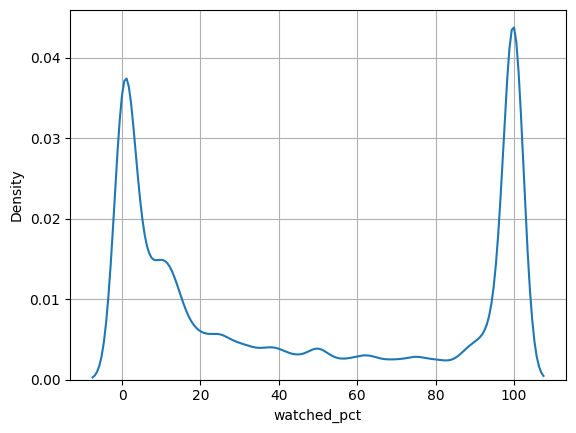

In [8]:
sns.kdeplot(data=df_inter, x='watched_pct')
plt.grid()

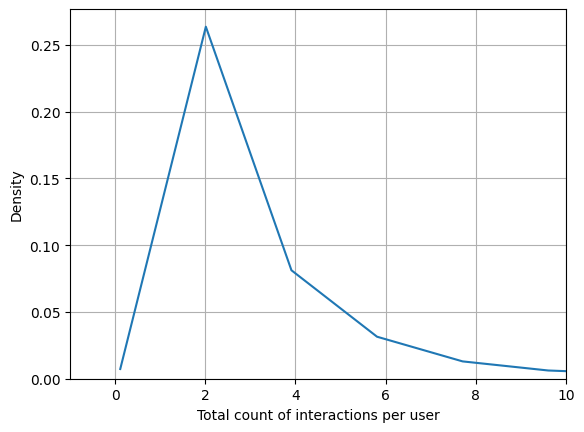

In [9]:
sns.kdeplot(df_inter.groupby('user_id').size())
plt.xlim([-1, 10])
plt.xlabel('Total count of interactions per user')
plt.grid()

### Preparation

In [22]:
df_inter.tail(3)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1288994,32937,10954,2021-05-13,71.0,1.0
1288995,311112,4151,2021-07-06,1480.0,13.0
1288996,498722,6143,20,NaN,NaN


In [23]:
# drop defect interaction
df_inter.drop(index=len(df_inter)-1, inplace=True)

# total_dur is fully correlated with watched_pct.
df_inter.drop(['total_dur'], axis=1, inplace=True)

df_inter['watched_pct'] = df_inter['watched_pct'].fillna(50.)

In [25]:
df_inter.sample(1)

,user_id,item_id,last_watch_dt,watched_pct
799775,1052310,12820,2021-06-27,17.0


Save modified data to new csv-file.

In [26]:
df_inter.to_csv('./mod_data/interactions.csv', index=False)

## Items

### Overview

In [27]:
df_items.describe(include='object')

,content_type,title,title_orig,genres,countries,studios,directors,actors,description,keywords
count,11909,11909,9090,11909,11894,755,11039,10156,11908,11502
unique,2,11461,8631,2273,635,37,6541,9943,11674,11459
top,film,Охота,Pet Sematary,документальное,США,HBO,Оливье Шиабоду,Александр Клюквин,МТС «Карантинники» — это домашние акустические...,"2015, чехия, компания, трех"
freq,9189,4,4,634,3337,242,388,20,35,6


In [28]:
df_items['content_type'].value_counts()

content_type
film      9189
series    2720
Name: count, dtype: int64

In [29]:
df_items['age_rating'].value_counts().sort_index()

age_rating
0.0     1053
6.0     1038
12.0    2915
16.0    4335
18.0    2108
21.0     459
Name: count, dtype: int64

In [30]:
df_items['genres'].value_counts()

genres
документальное                                           634
драмы                                                    614
комедии                                                  474
для взрослых                                             459
мелодрамы, комедии                                       236
                                                        ... 
фантастика, зарубежные, семейное, комедии                  1
русские, приключения, исторические, семейное, фэнтези      1
советские, экранизации, комедии                            1
драмы, зарубежные, боевики, ужасы                          1
драмы, спорт, криминал                                     1
Name: count, Length: 2273, dtype: int64

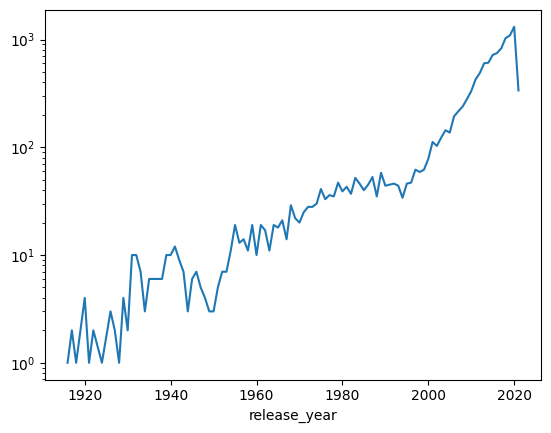

In [31]:
df_items['release_year'].value_counts().sort_index().plot(logy=True);

In [32]:
listoflists = df_items['keywords'].apply(lambda line: str(line).split(', '))
keywords = [word for line in listoflists for word in line]
pd.Series(keywords).value_counts().head(10)

отношения            5575
соединенные штаты    2611
Россия               2050
женщины              1637
любовь               1591
США                  1497
борьба               1374
мужчины              1366
преодоление          1283
трудностей           1281
Name: count, dtype: int64

In [33]:
df_items.sample(1)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
4637,16165,series,Стартап,NaN,2018.0,"зарубежные, семейное, комедии",США,NaN,12.0,Sony Pictures,"Зак Брафф, Майкл Патрик Джэнн, Ричи Кин","Боб Кленденин, Зак Брафф, Майкл Империоли, Мор...",Комедийное шоу о кризисе среднего возраста при...,"Стартап, 2018, США, бизнес, брак, работа, семе..."


### Preparation

In [40]:
df_items_mod = df_items.drop(
    ['title_orig', 'release_year', 'countries', 'for_kids', 'studios',
     'directors', 'actors', 'description'], axis=1)

In [41]:
df_items_mod.isnull().sum()

item_id           0
content_type      0
title             0
genres            0
age_rating        1
keywords        407
dtype: int64

In [42]:
df_items_mod['age_rating'] = df_items_mod['age_rating'].fillna(0)
df_items_mod['age_rating'] = df_items_mod['age_rating'].astype(int)
df_items_mod['age_rating'] = df_items_mod['age_rating'].astype('object')

In [43]:
df_items_mod.sample(1)

,item_id,content_type,title,genres,age_rating,keywords
6222,14260,film,Легендарные крушения Корсики,документальное,12,"2020, франция, легендарные, крушения, корсики"


In [44]:
df_items_mod.to_csv('./mod_data/items.csv', index=False)

## Users overview

### Overview

In [45]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448798 entries, 0 to 448797
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   448798 non-null  int64 
 1   age       443303 non-null  object
 2   income    443417 non-null  object
 3   sex       443377 non-null  object
 4   kids_flg  448798 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 17.1+ MB


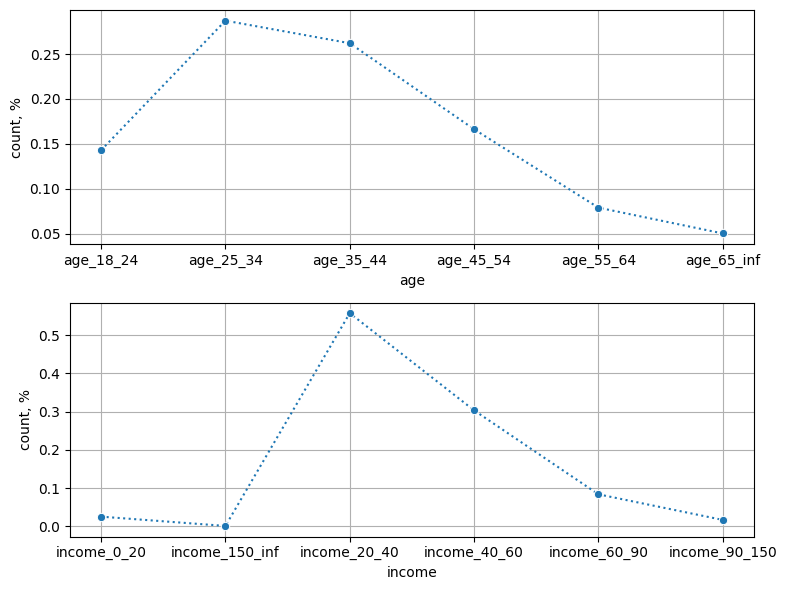

In [46]:
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
sns.lineplot(df_users['age'].value_counts().sort_index()/len(df_users), linestyle='dotted', marker='o')
plt.ylabel('count, %')
plt.grid()

plt.subplot(2, 1, 2)
sns.lineplot(df_users['income'].value_counts().sort_index()/len(df_users), linestyle='dotted', marker='o')
plt.ylabel('count, %')
plt.grid()

plt.tight_layout()

In [47]:
df_users.describe(include='object')

,age,income,sex
count,443303,443417,443377
unique,6,6,2
top,age_25_34,income_20_40,Ж
freq,128909,250031,225550


In [48]:
df_users['kids_flg'].value_counts()

kids_flg
0    305867
1    142931
Name: count, dtype: int64

### Preparation

In [49]:
df_users['kids_flg'] = df_users['kids_flg'].fillna(0)
df_users['age'] = df_users['age'].fillna('age_25_34')
df_users['income'] = df_users['income'].fillna('income_20_40')
df_users['sex'] = df_users['sex'].fillna('Ж')

In [51]:
df_users.to_csv('./mod_data/users.csv', index=False)